<div style="background-color:#e0f0ff; padding:20px; border-radius:10px;">
  <b style="color:#003366; font-size:2.5em;">Sticky Prices, Shifting Behaviour: Untangling Supply and Demand in U.S. Gasoline Markets</b>
</div>


## **Research Motivation**

Petrol markets exhibit complex interactions between price, supply, and consumer behaviour. This project investigates whether **prices drive consumer behaviour** or if **demand and supply dynamics push prices** — especially in light of **sticky prices** observed in administered markets.


## **The Theory Behind Our Work**

### A Keynesian View on Sticky Prices

According to Keynesian theory:
- In the **short run**, prices (especially for essential goods like petrol) do not adjust instantaneously.
- Instead, **quantities adjust**, making **behavioural responses (e.g., driving less)** a key margin for equilibrium.
  
This implies that:

> **Petrol price changes → changes in consumer behaviour**, rather than the reverse.

However, real-world markets are noisy:
- **Supply shocks** (e.g., refinery outages, OPEC decisions) may cause **price changes unrelated to demand**.
- **Macroeconomic and behavioural factors** (e.g., seasonal driving, economic cycles) may shift demand and indirectly affect prices.

<div style="border-left: 5px solid #2196F3; background-color: #E3F2FD; padding: 15px; margin-bottom: 20px;">
  <h3><strong>Hypothesis</strong></h3>
  <ul>
    <li><strong>H₀ (Null):</strong> Changes in petrol demand and supply levels cause immediate price fluctuations in the same period.</li>
    <li><strong>H₁ (Alternative):</strong> Changes in petrol demand and supply levels cause lagged price fluctuations.</li>
  </ul>
</div>


In [48]:
# Imports
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
import ruptures as rpt

In [2]:
# Import production and consumer data
prices_weekly = pd.read_csv('./data/weekly_gasoline_prices.csv')
supply_weekly = pd.read_csv('./data/weekly_supply_estimates.csv')
transport_monthly = pd.read_csv('./data/monthly_transportation_statistics.csv')

## **0. Data Preprocessing and Exploratory Data Analysis (EDA)**

We utilize the following datasets to examine trends in gasoline pricing, supply-demand dynamics, and transportation behavior. For each dataset, we identify specific variables of interest:

| **Dataset**                          | **Selected Variable**                                                                 | **Descriptions**                  |
|-------------------------------------|----------------------------------------------------------------------------------------|---------------------------------------|
| **Weekly Petrol Prices**            | `Price`                                                                                | Price reported for that week |
| **Weekly Supply Estimates**         | `Weekly U.S. Ending Stocks of Finished Motor Gasoline  (Thousand Barrels)`             | Total production of conventional motor gasoline which is defined as: finished motor gasoline not included in the oxygenated or reformulated gasoline categories                |
| **Monthly Transport Statistics**    | `Highway Vehicle Miles Travelled - All Systems`                                        | The Federal Highway Administration estimates vehicle miles travelled on all roads and streets in each month             |

### **0.1 `prices_weekly`**

We filter the dataset to focus exclusively on retail gasoline prices across all grades and formulations in the United States, then clean up unneeded columns for clarity and ease of analysis.

1. **Filter for gasoline price type**
* Keep only rows where 'Type' is 'All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon)'.

2. **Filter geography**
* Keep only rows where 'Geography' is 'US'.

3. **Drop irrelevant columns**
* Remove 'Type', 'Type_Clean', and 'Unit' columns — these are now redundant.

In [3]:
# Filter for the relevant gasoline price type
prices = prices_weekly.copy()[prices_weekly['Type'] == 'All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)']

# Keep only U.S. data
prices = prices[prices['Geography'] == 'US']

# Drop unnecessary columns
prices = prices.drop(columns=['Type', 'Type_Clean', 'Unit', 'Geography', 'Year']).reset_index(drop=True)

# Rename
prices = prices.rename(columns={
    'Date': 'date',
    'Year': 'year',
    'Price': 'price'
})

### **0.2 `supply_weekly`**

In [4]:
supply = supply_weekly.copy()[['Date', 'Weekly U.S. Ending Stocks of Finished Motor Gasoline  (Thousand Barrels)']]
supply = supply.rename(columns={
    'Date': 'date',
    'Weekly U.S. Ending Stocks of Finished Motor Gasoline  (Thousand Barrels)': 'motor_gasoline_barrels'
})

#### **Rationale for Using Weekly U.S. Ending Stocks of Finished Motor Gasoline as a Proxy for Supply and Demand**

The variable **`Weekly U.S. Ending Stocks of Finished Motor Gasoline (Thousand Barrels)`** represents the total inventory of conventional motor gasoline held in stock at the end of each week. This measure reflects the **finished motor gasoline** that is **not included in oxygenated or reformulated gasoline categories**, focusing solely on conventional gasoline production.

As such, it serves as a reliable **proxy for gasoline supply** for several reasons:

- **Inventory Levels Represent Supply Availability:** Ending stocks indicate how much gasoline is physically available in the market after production, imports, and consumption within the week.
- **Conventional Gasoline Focus:** By isolating finished conventional motor gasoline, this measure avoids complications from alternative fuel blends, providing a clearer view of mainstream gasoline supply.
- **Market Balancing Act:** Changes in ending stocks reflect the balance between supply and demand; when stocks decline, it often signals higher consumer demand relative to production, and vice versa.

While this variable primarily measures supply, it also **indirectly captures consumer demand dynamics**:

- **Demand Reduces Stocks:** Higher consumption by consumers reduces the inventory of finished motor gasoline, causing ending stocks to fall.
- **Supply-Demand Interaction:** Thus, weekly fluctuations in ending stocks embody the net effect of production and consumer usage, making it a practical, observable proxy that links supply with real-time demand pressure in the market.

In summary, by tracking **Weekly U.S. Ending Stocks of Finished Motor Gasoline**, we capture a vital indicator of gasoline availability and consumption behaviour, enabling insightful analysis of supply-demand trends in the U.S. gasoline market.

### **0.3 `transport`**

In [5]:
demand = transport_monthly.copy()[['Date', 'Highway Vehicle Miles Traveled - All Systems']].copy()
demand = demand.rename(columns={
    'Date': 'date',
    'Highway Vehicle Miles Traveled - All Systems': 'miles_travelled'
})

### **0.4 Preprocessing**

#### **Visualising missing data**

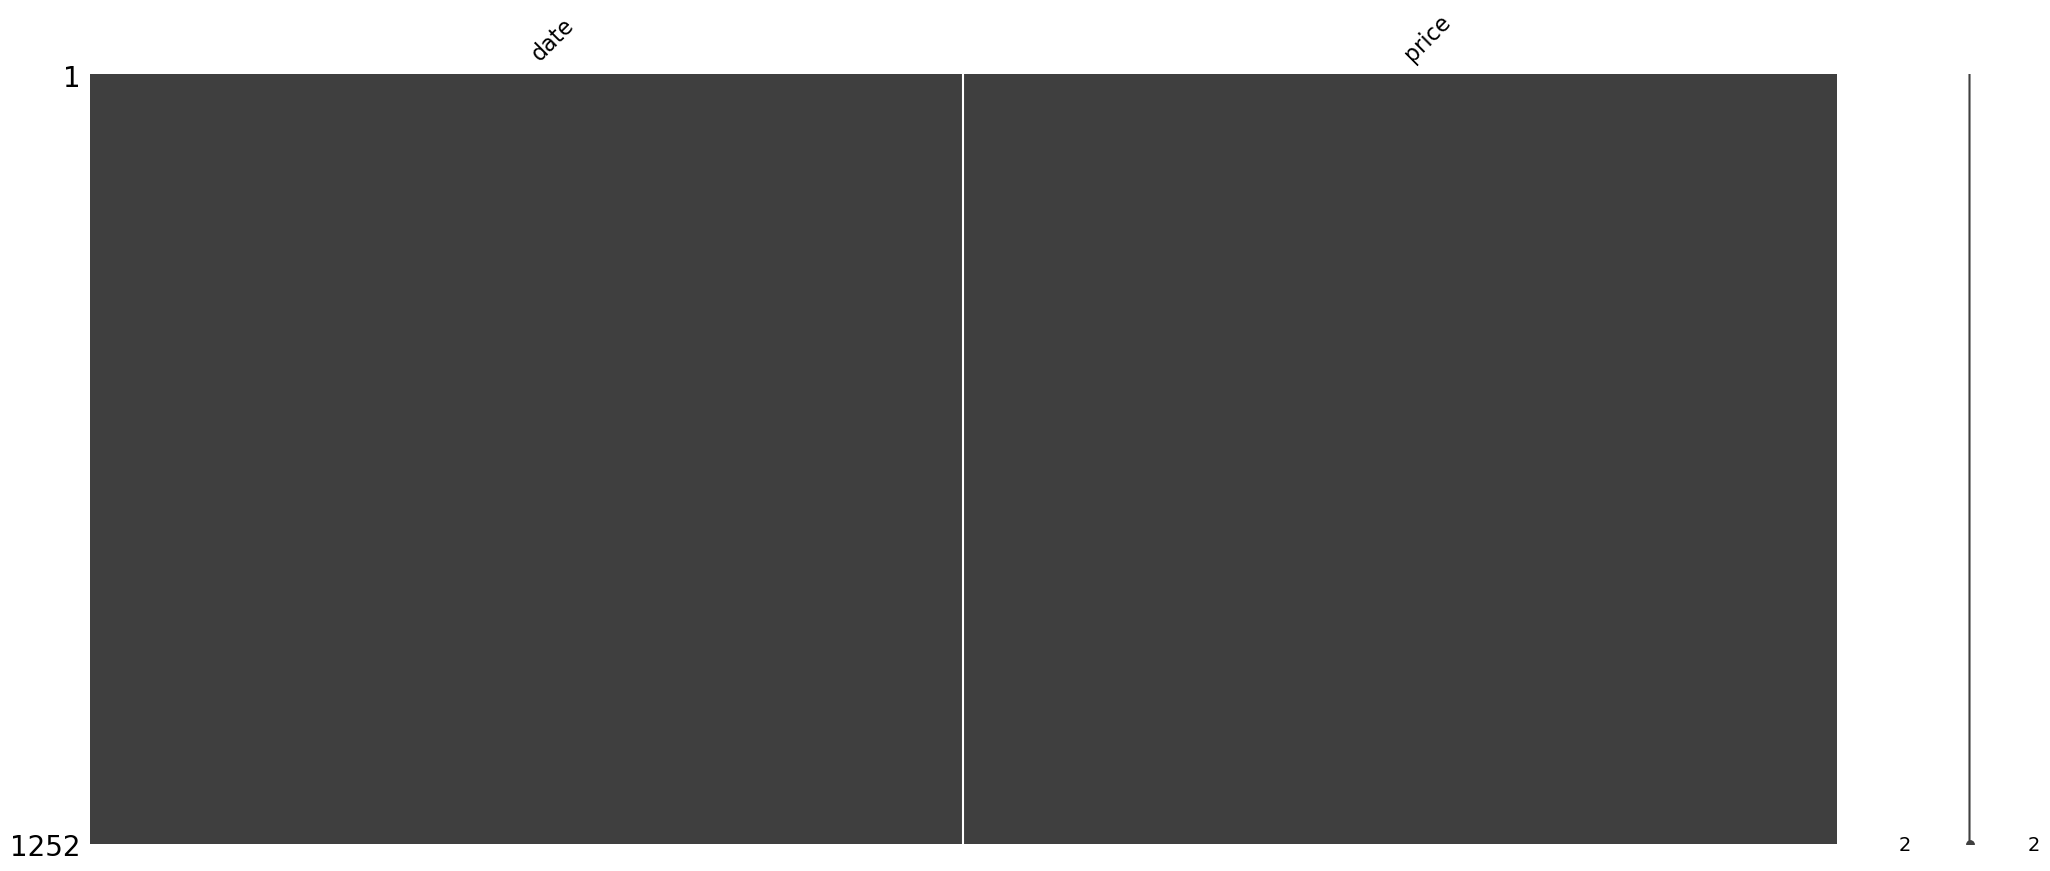

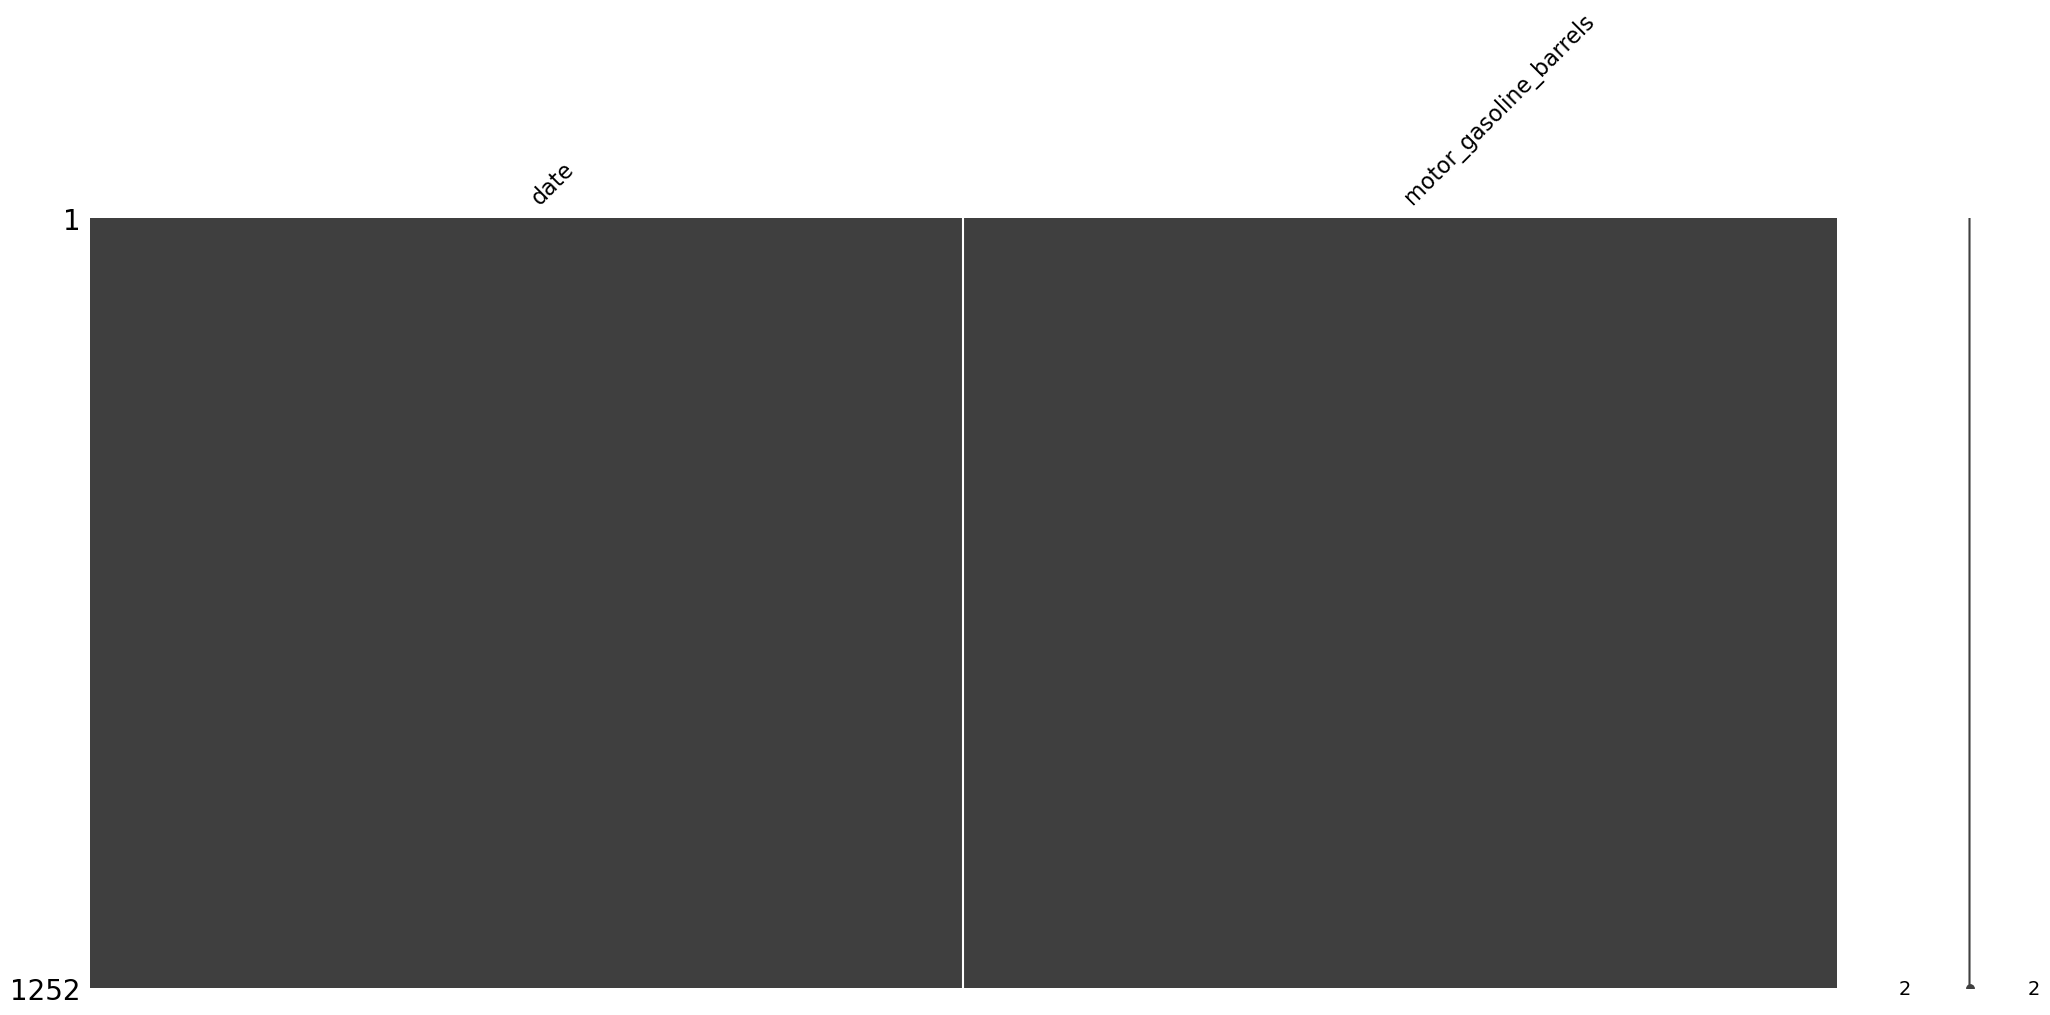

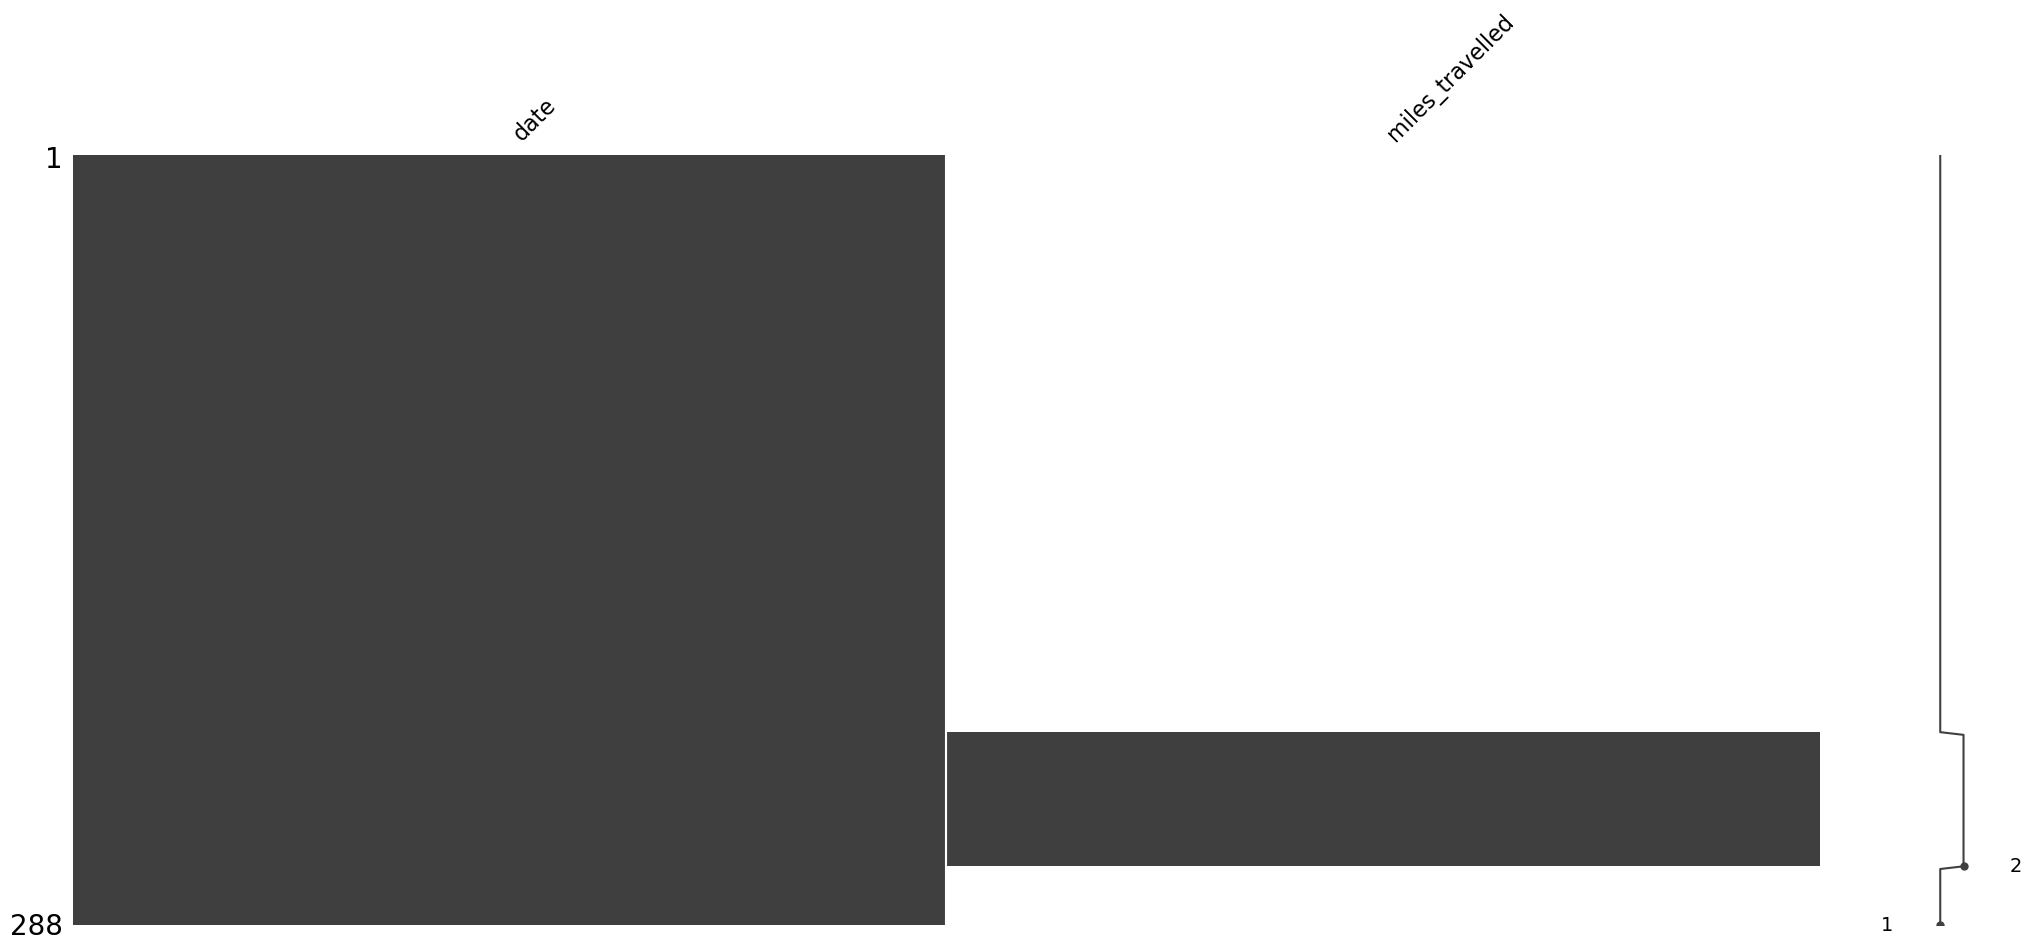

In [6]:
for df in [prices, supply, demand]:
    msno.matrix(df)
    plt.show()

In [7]:
# Drop NaNs in 'miles_travelled' and work on a copy to avoid SettingWithCopyWarning
demand = demand.dropna(subset=['miles_travelled']).copy()

# Convert 'date' to datetime
demand['date'] = pd.to_datetime(demand['date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

# Drop rows where datetime conversion failed
demand = demand.dropna(subset=['date'])

# Get min and max dates
start_date = demand['date'].min()
end_date = demand['date'].max()
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

print(f"Date range of demand: {start_date_str} to {end_date_str}")

# Format date column to "YYYY-MM-DD"
demand['date'] = demand['date'].dt.strftime('%Y-%m-%d')

# Reset index
demand = demand.reset_index(drop=True)

Date range of demand: 2018-01-01 to 2022-02-01


In [54]:
# Define date range
start_date = '2018-01-01'
end_date = '2022-12-31'

# Filter both DataFrames by the date range
prices = prices[(prices['date'] >= start_date) & (prices['date'] <= end_date)].reset_index(drop=True)
supply = supply[(supply['date'] >= start_date) & (supply['date'] <= end_date)].reset_index(drop=True)

### **0.5 Visualising Overall Trends**

**Structural Break Analysis**  
Detecting breaks in trends

In [59]:
def structural_break(column):
    # 1. Extract the time series (1D or multivariate)
    series = column.values

    # 2. Choose the model and algorithm
    # "l2" model detects changes in mean and variance, Pelt is efficient
    algo = rpt.Pelt(model="l2").fit(series)

    # 3. Select penalty or max number of breakpoints
    # Let's say max 5 breaks or penalty value
    breakpoints = algo.predict(pen=10)  # you may tune 'pen'

    # 4. Plot results with breakpoints
    rpt.display(series, breakpoints)
    plt.title("Structural Breaks in Petrol Prices")
    plt.show()

    # 5. Print break dates
    break_dates = prices['date'].iloc[[b-1 for b in breakpoints[:-1]]]  # last breakpoint is len(series)
    print("Detected break dates:")
    print(break_dates)

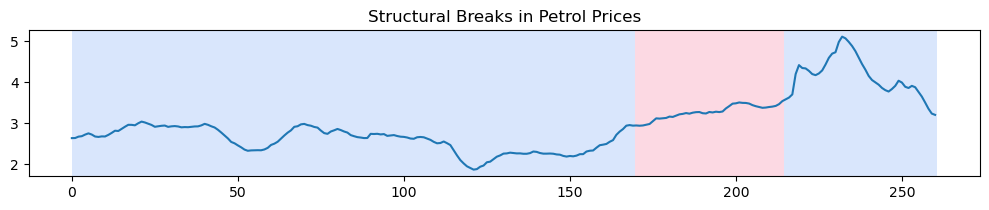

Detected break dates:
169   2021-03-29
214   2022-02-07
Name: date, dtype: datetime64[ns]


In [60]:
structural_break(prices['price'])

#### **Structural Break Analysis for Gasoline Prices**

**Detected Break Dates:**
- **2021-03-29**: Marks a significant shift due to post-COVID demand recovery, OPEC+ supply constraints, and fiscal stimulus in the U.S. These factors contributed to a sharp rise in crude oil and gasoline prices.
- **2022-02-07**: Occurs shortly before the Russian invasion of Ukraine (Feb 24, 2022), likely reflecting market anticipation of geopolitical tensions and supply disruptions, leading to increased price volatility and a subsequent spike in fuel prices.


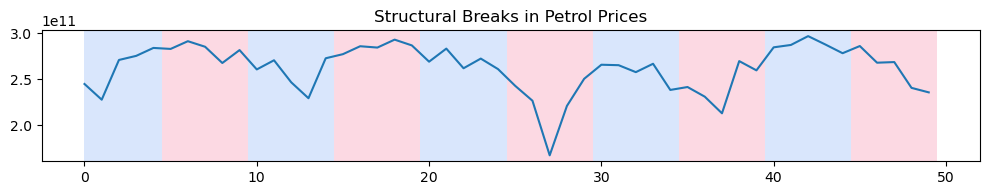

Detected break dates:
4    2018-01-29
9    2018-03-05
14   2018-04-09
19   2018-05-14
24   2018-06-18
29   2018-07-23
34   2018-08-27
39   2018-10-01
44   2018-11-05
Name: date, dtype: datetime64[ns]


In [61]:
structural_break(demand['miles_travelled'])

#### **Structural Break Analysis for Highway Vehicle Miles Traveled (Demand)**

**Detected Break Dates (2018):**
- A regular pattern of structural breaks was detected approximately every 5 weeks from **Jan to Nov 2018**.
- This likely reflects **seasonal fluctuations** in driving behavior, including:
  - **Weather effects** (e.g., fewer miles in winter, more in summer)
  - **Holiday-related travel spikes** (e.g., Spring Break, Memorial Day, Labor Day)
  - **Economic consistency**: No major economic shocks occurred in 2018, supporting the interpretation of cyclical, rather than structural, influences on demand.
- Suggests that **demand is highly seasonal**, with frequent shifts likely driven by **calendar effects** rather than external shocks.

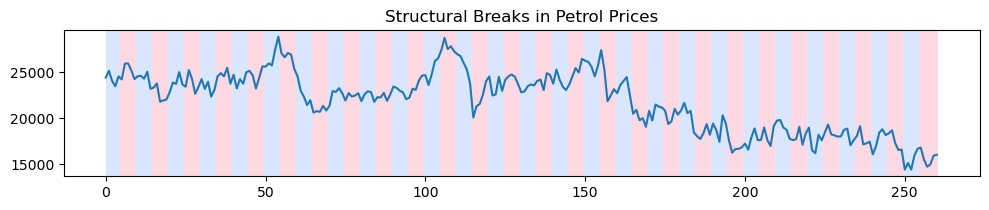

Detected break dates:
4     2018-01-29
9     2018-03-05
14    2018-04-09
19    2018-05-14
24    2018-06-18
29    2018-07-23
34    2018-08-27
39    2018-10-01
44    2018-11-05
49    2018-12-10
54    2019-01-14
59    2019-02-18
64    2019-03-25
69    2019-04-29
74    2019-06-03
79    2019-07-08
84    2019-08-12
89    2019-09-16
94    2019-10-21
99    2019-11-25
104   2019-12-30
109   2020-02-03
114   2020-03-09
119   2020-04-13
124   2020-05-18
129   2020-06-22
134   2020-07-27
139   2020-08-31
144   2020-10-05
149   2020-11-09
154   2020-12-14
159   2021-01-18
164   2021-02-22
169   2021-03-29
174   2021-05-03
179   2021-06-07
184   2021-07-12
189   2021-08-16
194   2021-09-20
199   2021-10-25
204   2021-11-29
209   2022-01-03
214   2022-02-07
219   2022-03-14
224   2022-04-18
229   2022-05-23
234   2022-06-27
239   2022-08-01
244   2022-09-05
249   2022-10-10
254   2022-11-14
Name: date, dtype: datetime64[ns]


In [62]:
structural_break(supply['motor_gasoline_barrels'])

#### **Structural Break Analysis for Motor Gasoline Supply (Barrels)**

**Detected Break Dates (2018–2022):**
- Structural breaks occur at **regular ~5-week intervals** across the entire period, from **Jan 2018 to Nov 2022**.
- This consistent timing suggests **cyclical adjustments** in gasoline supply, likely tied to:
  - **Seasonal demand patterns** (e.g., summer driving season, holiday travel)
  - **Inventory management cycles** by refineries and distributors
  - **Regulatory or reporting calendar effects** (e.g., monthly or quarterly adjustments)

- No abrupt structural shocks are evident, except:
  - **Early 2020** (Mar–May): aligns with **COVID-19 onset**, where sharp drops in mobility may have disrupted normal supply cycles.
  - **Early 2022**: break around **Feb 2022** may be linked to supply chain responses to **Russia–Ukraine tensions**.

Overall, the data reflects a **highly regular, seasonal supply pattern** with notable disruptions during major global events.

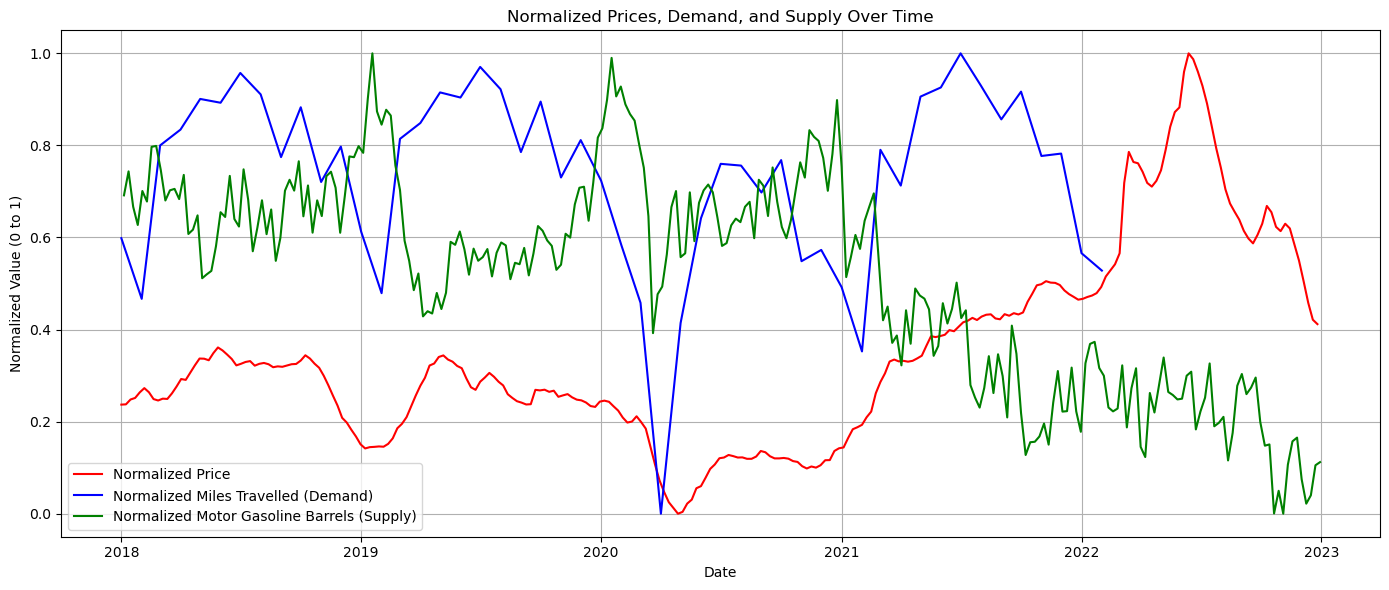

In [9]:
# Ensure date columns are in datetime format
prices['date'] = pd.to_datetime(prices['date'])
demand['date'] = pd.to_datetime(demand['date'])
supply['date'] = pd.to_datetime(supply['date'])

def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Apply normalization
prices['price_norm'] = normalize(prices['price'])
demand['miles_travelled_norm'] = normalize(demand['miles_travelled'])
supply['motor_gasoline_barrels_norm'] = normalize(supply['motor_gasoline_barrels'])

plt.figure(figsize=(14, 6))

plt.plot(prices['date'], prices['price_norm'], label='Normalized Price', color='red')
plt.plot(demand['date'], demand['miles_travelled_norm'], label='Normalized Miles Travelled (Demand)', color='blue')
plt.plot(supply['date'], supply['motor_gasoline_barrels_norm'], label='Normalized Motor Gasoline Barrels (Supply)', color='green')

plt.xlabel('Date')
plt.ylabel('Normalized Value (0 to 1)')
plt.title('Normalized Prices, Demand, and Supply Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Analysis**

- **Early 2020 Collapse (COVID-19 Onset):**
  - Sharp simultaneous dip in price, demand, and supply around March–April 2020.
  - Reflects global COVID-19 impact:
    - Demand (miles driven) plummeted.
    - Prices fell sharply.
    - Supply adjusted downward but with some lag.

- **Post-2020 Recovery:**
  - Demand recovers faster than supply and price, peaking in 2021.
  - Prices start rising steadily through 2021 and into early 2022.
  - Supply remains volatile, with a declining trend from 2021 onwards.

- **2022 Price Spike:**
  - Prices peak around mid-2022, possibly due to global oil market shocks (e.g., Russia-Ukraine war).
  - Demand remains high, but supply continues to drop, suggesting supply constraints driving the price surge.

- **2022–2023 Slowdown:**
  - All three variables decline into 2023, possibly due to inflation, policy tightening, or post-pandemic demand normalization.


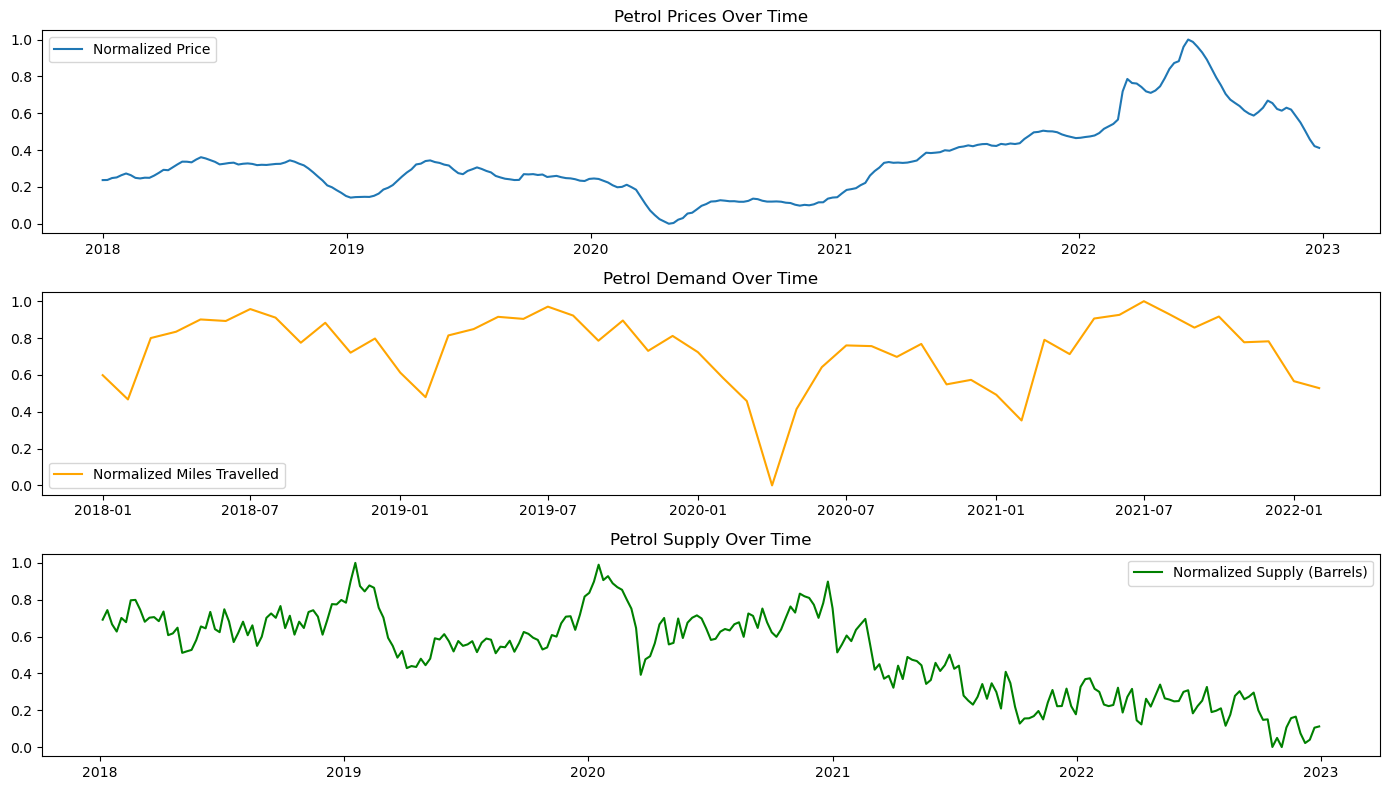

In [32]:
plt.figure(figsize=(14,8))

plt.subplot(3,1,1)
plt.plot(prices['date'], prices['price_norm'], label='Normalized Price')
plt.title('Petrol Prices Over Time')
plt.legend()

plt.subplot(3,1,2)
plt.plot(demand['date'], demand['miles_travelled_norm'], label='Normalized Miles Travelled', color='orange')
plt.title('Petrol Demand Over Time')
plt.legend()

plt.subplot(3,1,3)
plt.plot(supply['date'], supply['motor_gasoline_barrels_norm'], label='Normalized Supply (Barrels)', color='green')
plt.title('Petrol Supply Over Time')
plt.legend()

plt.tight_layout()
plt.show()


#### **Analysis**
1. **Prices**
   - Fairly stable until 2020, then sharp dip followed by strong rally peaking in 2022.
   - Matches known trends in global fuel markets (pandemic crash + post-pandemic inflation + supply constraints).

2. **Demand**
   - Peaks consistently during mid-years (summer driving seasons).
   - Severe dip during early 2020.
   - Recovers strongly by 2021, then slowly declines post-2022, possibly due to economic slowdown or behavior change.

3. **Supply**
   - More volatile and erratic.
   - Peak supply precedes price peaks (supply often leads prices, visible in 2019 and 2021).
   - Overall declining trend from mid-2021 through 2023.

#### **Leading & Lagging Relationships**
*Preliminary Analysis*

| Scenario                                        | Observed?             | Timing Relationship           | Evidence from Plots                                                                                                                                                 | Supports H₁ (Lagged Effect)? |
|------------------------------------------------|-----------------------|-------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------|
| **Demand ↑ and Price ↑ in same period**         | No (not consistent) | **Prices tend to lag** demand | In 2021, normalized demand (blue) rises significantly ahead of the steep price (red) rise in 2022. Price increases follow rising travel activity with delay.        | **Yes**                    |
| **Price increases lag behind demand increases** | Yes                 | Clear lag                     | Repeated pattern in mid-2020 to 2022: demand picks up before prices respond.                                                                                        | **Yes**                    |
| **Supply ↓ and Price ↑ in same period**         | Sometimes           | Often simultaneous            | In late 2021 and early 2022, supply (green) and price (red) move in opposite directions **within the same time window**, suggesting a contemporaneous supply shock. | ⚠️ **Partially**             |
| **Price increases lag behind supply decreases** | Sometimes           | Mild lag                      | In some intervals (e.g., late 2020), a drop in supply precedes a price rise, but timing is less consistent than with demand.                                        | **Yes (weaker)**           |


#### **Significant Trends**

- **Pandemic Impact (2020):** All variables crashed simultaneously—a major exogenous shock.

- **2021–2022 Recovery:** Demand and prices rebounded; supply did not fully recover → upward pressure on prices.

- **2022 Peak:** Price spikes while supply falls and demand remains elevated.

- **2023 Decline:** All variables decline—possible economic cooling or policy effects.

## **1 Correlation Analysis**

### **1.1 Demand and Prices**

**Aligning the dates to test if price lags demand**

In [55]:
def match_after(dates_left, dates_right):
    # For each date in left, find the closest date in right that is >= left date
    matched_indices = []
    for d in dates_left:
        candidates = dates_right[dates_right >= d]
        if not candidates.empty:
            matched_indices.append(candidates.min())
        else:
            matched_indices.append(pd.NaT)
    return matched_indices

# Match price dates after demand dates
matched_price_dates = match_after(demand['date'], prices['date'])

# Build dataframe with demand and matched prices
demand_price_df = demand.copy()
demand_price_df['matched_price_date'] = matched_price_dates

# Merge price values on matched price dates
demand_price_df = demand_price_df.merge(prices[['date','price_norm']], left_on='matched_price_date', right_on='date', how='left', suffixes=('','_price'))

# Drop rows where no matched price date
demand_price_df = demand_price_df.dropna(subset=['price_norm'])

**Correlation of demand vs future prices**

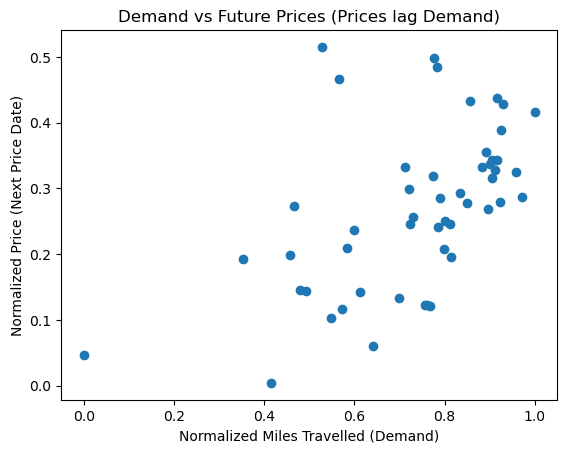

Correlation: 0.5313201535149632


In [56]:
plt.scatter(demand_price_df['miles_travelled_norm'], demand_price_df['price_norm'])
plt.xlabel('Normalized Miles Travelled (Demand)')
plt.ylabel('Normalized Price (Next Price Date)')
plt.title('Demand vs Future Prices (Prices lag Demand)')
plt.show()

print('Correlation:', demand_price_df[['miles_travelled_norm','price_norm']].corr().iloc[0,1])

**Cross-Correlation Function between demand and price**

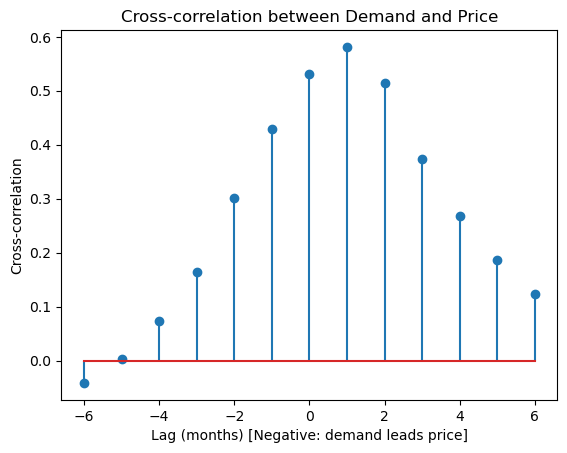

In [57]:
# Resample to monthly (first day)
prices_monthly = prices.set_index('date').resample('MS').first().dropna()
demand_monthly = demand.set_index('date').resample('MS').first().dropna()

# Align on common dates only
common_dates = prices_monthly.index.intersection(demand_monthly.index)
prices_aligned = prices_monthly.loc[common_dates]['price_norm']
demand_aligned = demand_monthly.loc[common_dates]['miles_travelled_norm']

# Compute cross-correlation
lags = np.arange(-6,7)
ccf_values = [np.corrcoef(demand_aligned.shift(lag).dropna(), prices_aligned.loc[demand_aligned.shift(lag).dropna().index])[0,1] for lag in lags]

plt.stem(lags, ccf_values)
plt.xlabel('Lag (months) [Negative: demand leads price]')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between Demand and Price')
plt.show()


**Granger Causality Test**

In [43]:
# Merge demand and price monthly (on common dates)
df_gc = pd.concat([demand_aligned, prices_aligned], axis=1).dropna()
df_gc.columns = ['demand', 'price']

maxlag = 6
print("Granger Causality: Demand causing Price")
grangercausalitytests(df_gc[['price','demand']], maxlag=maxlag, verbose=True)

print("\nGranger Causality: Price causing Demand")
grangercausalitytests(df_gc[['demand','price']], maxlag=maxlag, verbose=True)


Granger Causality: Demand causing Price

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0983  , p=0.7553  , df_denom=46, df_num=1
ssr based chi2 test:   chi2=0.1047  , p=0.7463  , df=1
likelihood ratio test: chi2=0.1046  , p=0.7464  , df=1
parameter F test:         F=0.0983  , p=0.7553  , df_denom=46, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1668  , p=0.1269  , df_denom=43, df_num=2
ssr based chi2 test:   chi2=4.8375  , p=0.0890  , df=2
likelihood ratio test: chi2=4.6090  , p=0.0998  , df=2
parameter F test:         F=2.1668  , p=0.1269  , df_denom=43, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5110  , p=0.2264  , df_denom=40, df_num=3
ssr based chi2 test:   chi2=5.3264  , p=0.1494  , df=3
likelihood ratio test: chi2=5.0456  , p=0.1685  , df=3
parameter F test:         F=1.5110  , p=0.2264  , df_denom=40, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F te

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (0.21184011010154127, 0.6474973132342644, 46.0, 1),
   'ssr_chi2test': (0.2256557694559896, 0.6347638885800595, 1),
   'lrtest': (0.22513776199892277, 0.6351527797080747, 1),
   'params_ftest': (0.21184011010155843, 0.6474973132342525, 46.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.0524347377239855, 0.35790522732345786, 43.0, 2),
   'ssr_chi2test': (2.3496217400349444, 0.3088773921398514, 2),
   'lrtest': (2.2939245896369584, 0.31760008092152936, 2),
   'params_ftest': (1.0524347377239784, 0.3579052273234588, 43.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.26964254149551353, 0.8468946274816445, 40.0, 3),
   'ssr_chi2test': (0.9504899587716852, 0.8132294283286283, 3),
   'lrtest': (0.9410066312169647, 0.8155223597166218, 3),
   'params_ftest': (0.26964254149551464, 0.8468946274816445, 40.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.,

**VAR model**

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 17, May, 2025
Time:                     23:21:20
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -13.8975
Nobs:                     48.0000    HQIC:                  -14.4068
Log likelihood:           169.861    FPE:                4.08864e-07
AIC:                     -14.7162    Det(Omega_mle):     2.71778e-07
--------------------------------------------------------------------
Results for equation price
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.099393         0.045953            2.163           0.031
L1.price          1.322833         0.168563            7.848           0.000
L1.demand         0.022556         0.045436            0.496           0.620

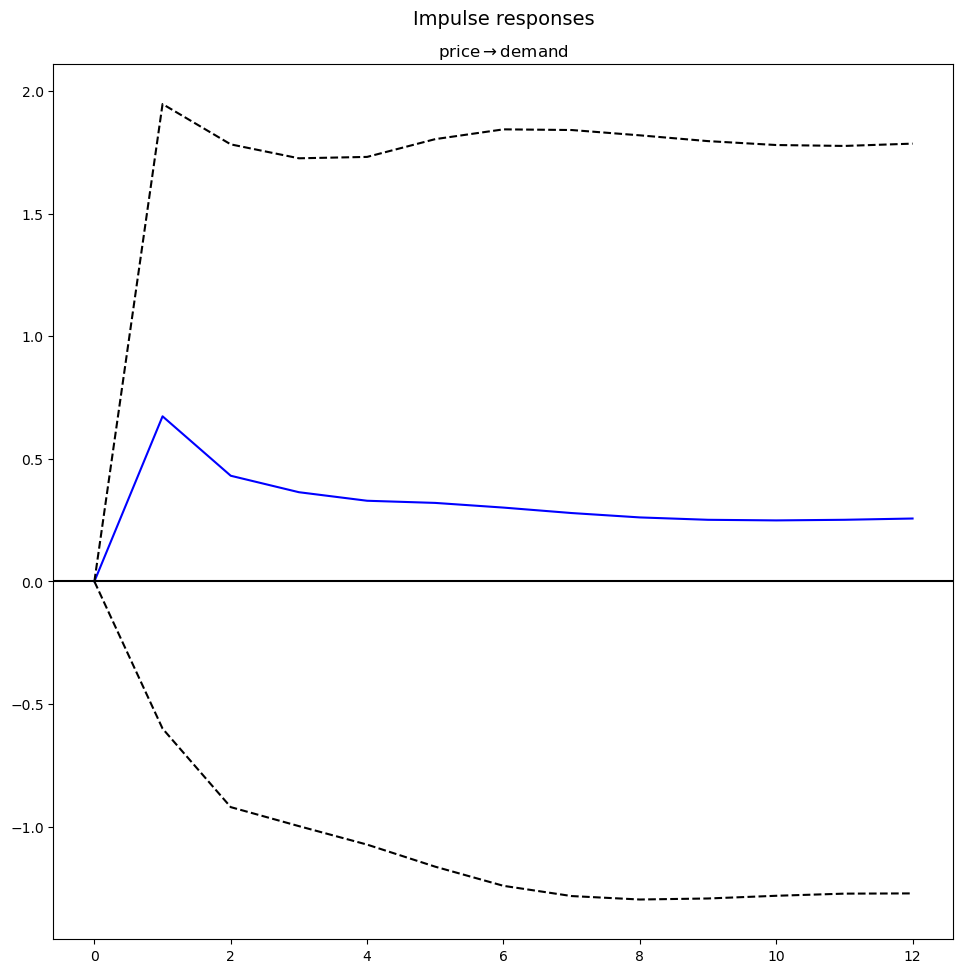

In [46]:
# Prepare monthly data for VAR - resample and align all three on month start
prices_monthly = prices.set_index('date').resample('MS').first()[['price_norm']].dropna()
demand_monthly = demand.set_index('date').resample('MS').first()[['miles_travelled_norm']].dropna()
supply_monthly = supply.set_index('date').resample('MS').first()[['motor_gasoline_barrels_norm']].dropna()

# Combine dataframes on intersection of dates
common_index = prices_monthly.index.intersection(demand_monthly.index).intersection(supply_monthly.index)
df_var = pd.concat([
    prices_monthly.loc[common_index],
    demand_monthly.loc[common_index],
    supply_monthly.loc[common_index]
], axis=1)

df_var.columns = ['price', 'demand', 'supply']

# Fit VAR
model = VAR(df_var)
results = model.fit(maxlags=6, ic='aic')

print(results.summary())

# Impulse response function: effect of a shock to price on demand
irf = results.irf(12)
irf.plot(impulse='price', response='demand')
plt.show()